### Data Preparation

In [217]:
from dotenv import load_dotenv
import os
load_dotenv()

import pandas as pd
import re
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [218]:
co2_emitters = pd.read_excel('data/epa_ghrp_emitters.xls', skiprows=6, header=0)
# co2_emitters_gdf = gpd.GeoDataFrame(emitters, 
#                                   geometry=gpd.points_from_xy(emitters['LONGITUDE'], emitters['LATITUDE']),
#                                   crs='EPSG:4326')

electronics_co_buyers = pd.read_excel('data/epa_ghrp_co_buyers_electronics_manufacturing.xls', skiprows=6, header=0)
electronics_co_buyers['SECTOR'] = 'Petrochemical Production' 
petrochem_co_buyers = pd.read_excel('data/epa_ghrp_co_buyers_petrochem_prod.xls', skiprows=6, header=0)
petrochem_co_buyers['SECTOR'] = 'Electronics Manufacturing' 

co_buyers = pd.concat([electronics_co_buyers, petrochem_co_buyers], ignore_index=True)
# co_buyers_gdf = gpd.GeoDataFrame(co_buyers, 
#                                   geometry=gpd.points_from_xy(co_buyers['LONGITUDE'], co_buyers['LATITUDE']),
#                                   crs='EPSG:4326')

def clean_column_names(df):
    df.columns = [re.sub(r'[\s()]', '_', c.upper()).replace("__", "_").replace("/", "_PER_").rstrip("_") for c in df.columns]

for df in [co2_emitters, co_buyers]:
    clean_column_names(df)

### Collecitng the best primary emitter candidates

In [219]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
from tqdm import tqdm

EARTH_RADIUS_KM = 6371.0088

def _to_radians(df):
    return np.deg2rad(df[["LATITUDE", "LONGITUDE"]].values)  # BallTree expects [lat, lon] in radians

def build_buyer_seller_graph_km(df_buyers, df_sellers, L_km=50.0):
    """
    Build a bipartite graph with edges between buyers and sellers within L_km (great-circle distance).
    Edge weights are stored in kilometers.
    """
    # Basic sanity: drop rows with missing coords
    buyers = df_buyers.dropna(subset=["LONGITUDE", "LATITUDE"]).copy()
    sellers = df_sellers.dropna(subset=["LONGITUDE", "LATITUDE"]).copy()

    # Build BallTree on sellers (haversine metric)
    sellers_rad = _to_radians(sellers)
    tree = BallTree(sellers_rad, metric="haversine")

    # Query buyers against sellers within radius (in radians)
    buyers_rad = _to_radians(buyers)
    r_rad = L_km / EARTH_RADIUS_KM
    ind_array, dist_array = tree.query_radius(buyers_rad, r=r_rad, return_distance=True, sort_results=True)

    # Graph
    G = nx.Graph()

    # Add sellers
    for _, row in sellers.iterrows():
        G.add_node(f"S_{row['GHGRP_ID']}",
                   bipartite="seller",
                   pos=(row["LONGITUDE"], row["LATITUDE"]))

    # Add buyers
    for _, row in buyers.iterrows():
        G.add_node(f"B_{row['GHGRP_ID']}",
                   bipartite="buyer",
                   pos=(row["LONGITUDE"], row["LATITUDE"]))

    # Add edges (distance in km)
    for b_idx, (seller_idxs, d_rads) in tqdm(enumerate(zip(ind_array, dist_array))):
        buyer_id = f"B_{buyers.iloc[b_idx]['GHGRP_ID']}"
        for s_idx, d_rad in zip(seller_idxs, d_rads):
            seller_id = f"S_{sellers.iloc[s_idx]['GHGRP_ID']}"
            d_km = float(d_rad * EARTH_RADIUS_KM)
            G.add_edge(buyer_id, seller_id, weight=d_km)

    return G

def plot_graph(G, title="Buyer–Seller Graph (great-circle distances in km)"):
    pos = nx.get_node_attributes(G, "pos")
    node_colors = ["lightgreen" if G.nodes[n].get("bipartite")=="buyer" else "skyblue" for n in G.nodes]

    plt.figure(figsize=(9, 7))
    nx.draw(
        G, pos,
        node_size=100,
        node_color=node_colors,
        edge_color="gray",
        with_labels=True,
        font_size=7
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.show()


def filter_sellers_km(G, df_sellers, x, j, L_km):
    """
    Return sellers with GHG QUANTITY >= x and at least j buyers with edge distance <= L_km (km).
    Assumes edge 'weight' is in km as built above.
    """
    # Map GHGRP_ID -> GHG QUANTITY
    seller_info = df_sellers.set_index("GHGRP_ID")["GHG_QUANTITY_METRIC_TONS_CO2E"].to_dict()
    qualified = []

    for node in G.nodes:
        if G.nodes[node].get("bipartite") != "seller":
            continue

        ghgrp_id = int(node.split("_", 1)[1])
        ghg_qty = seller_info.get(ghgrp_id, None)
        if ghg_qty is None or ghg_qty < x:
            continue

        # Collect buyers within L_km along with distances
        buyer_neighbors_with_d = [
            (nbr, data.get("weight", np.inf))
            for nbr, data in G[node].items()
            if G.nodes[nbr].get("bipartite") == "buyer" and data.get("weight", np.inf) <= L_km
        ]

        if len(buyer_neighbors_with_d) >= j:
            # Sort buyers by distance once
            buyer_neighbors_with_d.sort(key=lambda t: t[1])

            # Extract aligned lists
            buyer_ids_sorted = [int(nbr.split("_", 1)[1]) for nbr, _d in buyer_neighbors_with_d]
            distances_sorted = [round(float(d_km), 3) for _nbr, d_km in buyer_neighbors_with_d]

            buyers_csv = ",".join(map(str, buyer_ids_sorted))
            distances_csv = ",".join(map(str, distances_sorted))

            qualified.append({
                "CO2_EMITTER_ID": ghgrp_id,
                "GHG_QUANTITY": ghg_qty,
                f"BUYER_COUNT_WITHIN_{L_km}KM": len(buyer_neighbors_with_d),
                f"BUYER_GHGRP_IDS_WITHIN_{L_km}KM": buyers_csv,
                f"BUYER_DISTANCES_WITHIN_{L_km}KM": distances_csv
            })

    return pd.DataFrame(qualified)

In [220]:
print(co_buyers.shape, co2_emitters.shape)
G = build_buyer_seller_graph_km(co_buyers, co2_emitters, L_km=100)
candidates_base = filter_sellers_km(
    G, 
    co2_emitters, 
    5000, # minimum emissions quantity (Turnover Labs target)
    2, # minimum buyers available, 
    50 # maximum co_buyer distance (km)
)
candidates_base.head()

(121, 14) (7511, 13)


121it [00:00, 272.09it/s]


,CO2_EMITTER_ID,GHG_QUANTITY,BUYER_COUNT_WITHIN_50KM,BUYER_GHGRP_IDS_WITHIN_50KM,BUYER_DISTANCES_WITHIN_50KM
0,1004377,288302,4,"1010134,1008059,1011813,1003945","33.639,37.416,37.904,45.42"
1,1012507,286498,9,"1007002,1001711,1002859,1001713,1002758,100665...","23.497,24.818,25.38,28.51,29.195,31.341,32.968..."
2,1009170,13382,2,"1007002,1002859","48.945,49.823"
3,1012472,92930,9,"1007002,1001711,1002859,1001713,1002758,100665...","23.497,24.818,25.38,28.51,29.195,31.341,32.968..."
4,1012466,89986,9,"1007002,1001711,1002859,1001713,1002758,100665...","23.497,24.818,25.38,28.51,29.195,31.341,32.968..."


### Feature Engineering

In [221]:
# Emittor Dataset Attribution
candidates = candidates_base.merge(
    co2_emitters.drop(["GHG_QUANTITY_METRIC_TONS_CO2E"], axis=1), 
    left_on="CO2_EMITTER_ID", 
    right_on="GHGRP_ID", 
    how="left"
)

# Turnover Labs Conversion Factors
candidates.rename(columns={"GHG_QUANTITY": "CO2_EMISSIONS_MT"}, inplace=True)
candidates.insert(2, "TL_COPROD_MT", candidates["CO2_EMISSIONS_MT"] * (63 / 100))
candidates.insert(3, "TL_COPROD_ELECTRUSAGE_FULLUTIL_KWH", candidates["TL_COPROD_MT"]*4830)
candidates.insert(4, "TL_CH30HPROD_MT", candidates["CO2_EMISSIONS_MT"] * (72 / 100))
candidates.insert(5, "TL_CH30HPROD_ELECTRUSAGE_FULLUTIL_KWH", candidates["TL_CH30HPROD_MT"]*5320)
candidates.head()

,CO2_EMITTER_ID,CO2_EMISSIONS_MT,TL_COPROD_MT,TL_COPROD_ELECTRUSAGE_FULLUTIL_KWH,TL_CH30HPROD_MT,TL_CH30HPROD_ELECTRUSAGE_FULLUTIL_KWH,BUYER_COUNT_WITHIN_50KM,BUYER_GHGRP_IDS_WITHIN_50KM,BUYER_DISTANCES_WITHIN_50KM,REPORTING_YEAR,FACILITY_NAME,GHGRP_ID,REPORTED_ADDRESS,LATITUDE,LONGITUDE,CITY_NAME,COUNTY_NAME,STATE,ZIP_CODE,PARENT_COMPANIES,SUBPARTS
0,1004377,288302,181630.26,877274155.8,207577.44,1.104312e+09,4,"1010134,1008059,1011813,1003945","33.639,37.416,37.904,45.42",2023,121 REGIONAL DISPOSAL FACILITY,1004377,3820 SAM RAYBURN HIGHWAY,33.29857,-96.535860,MELISSA,COLLIN COUNTY,TX,75454,NORTH TEXAS MUNICIPAL WATER DISTRICT (100%),HH
1,1012507,286498,180493.74,871784764.2,206278.56,1.097402e+09,9,"1007002,1001711,1002859,1001713,1002758,100665...","23.497,24.818,25.38,28.51,29.195,31.341,32.968...",2023,220 Gulf Coast Basin,1012507,"811 Louisiana, Suite 2100",29.75993,-95.366413,Houston,HARRIS COUNTY,TX,77002,TARGA RESOURCES CORP (100%),W
2,1009170,13382,8430.66,40720087.8,9635.04,5.125841e+07,2,"1007002,1002859","48.945,49.823",2023,260 East Texas Basin - BP America Production C...,1009170,501 Westlake Park Blvd.,29.78037,-95.629500,Houston,NaN,TX,77079,BP AMERICA INC (100%),W
3,1012472,92930,58545.90,282776697.0,66909.60,3.559591e+08,9,"1007002,1001711,1002859,1001713,1002758,100665...","23.497,24.818,25.38,28.51,29.195,31.341,32.968...",2023,345 Arkoma Basin,1012472,"811 Louisiana, Suite 2100",29.75993,-95.366413,Houston,HARRIS COUNTY,TX,77002,TARGA RESOURCES CORP (100%),W
4,1012466,89986,56691.18,273818399.4,64789.92,3.446824e+08,9,"1007002,1001711,1002859,1001713,1002758,100665...","23.497,24.818,25.38,28.51,29.195,31.341,32.968...",2023,350 South Oklahoma Folded Belt,1012466,"811 Louisiana, Suite 2100",29.75993,-95.366413,Houston,HARRIS COUNTY,TX,77002,TARGA RESOURCES CORP (100%),W


In [222]:
power_price_df = pd.read_excel('data/monthly_power_price_by_state_eia_may_2025.xls')
# https://www.eia.gov/electricity/monthly/epm_table_grapher.php?t=epmt_5_6_a
clean_column_names(power_price_df)

us_states_to_acronyms = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY',
    'District of Columbia': 'DC', 'American Samoa': 'AS', 'Guam': 'GU',
    'Northern Mariana Islands': 'MP', 'Puerto Rico': 'PR', 'U.S. Virgin Islands': 'VI'
}
power_price_df['STATE_ABBR'] = power_price_df['CENSUS_DIVISION_OR_STATE'].map(us_states_to_acronyms)
state_to_power_price_dict = dict(zip(power_price_df['STATE_ABBR'], power_price_df['INDUSTRIAL_MAY_25']))

candidates.insert(4, "TL_COPROD_ELECTRUSAGE_FULLUTIL_COST_USD", 
                  [state_to_power_price_dict[state] * kwh_usage / 100 for state, kwh_usage in zip(candidates['STATE'], candidates['TL_COPROD_ELECTRUSAGE_FULLUTIL_KWH'])]
)
candidates.insert(7, "TL_CH30HPROD_ELECTRUSAGE_FULLUTIL_COST_USD", 
                  [state_to_power_price_dict[state] * kwh_usage / 100 for state, kwh_usage in zip(candidates['STATE'], candidates['TL_CH30HPROD_ELECTRUSAGE_FULLUTIL_KWH'])]
)
candidates.head()

,CO2_EMITTER_ID,CO2_EMISSIONS_MT,TL_COPROD_MT,TL_COPROD_ELECTRUSAGE_FULLUTIL_KWH,TL_COPROD_ELECTRUSAGE_FULLUTIL_COST_USD,TL_CH30HPROD_MT,TL_CH30HPROD_ELECTRUSAGE_FULLUTIL_KWH,TL_CH30HPROD_ELECTRUSAGE_FULLUTIL_COST_USD,BUYER_COUNT_WITHIN_50KM,BUYER_GHGRP_IDS_WITHIN_50KM,BUYER_DISTANCES_WITHIN_50KM,REPORTING_YEAR,FACILITY_NAME,GHGRP_ID,REPORTED_ADDRESS,LATITUDE,LONGITUDE,CITY_NAME,COUNTY_NAME,STATE,ZIP_CODE,PARENT_COMPANIES,SUBPARTS
0,1004377,288302,181630.26,877274155.8,5.816328e+07,207577.44,1.104312e+09,7.321588e+07,4,"1010134,1008059,1011813,1003945","33.639,37.416,37.904,45.42",2023,121 REGIONAL DISPOSAL FACILITY,1004377,3820 SAM RAYBURN HIGHWAY,33.29857,-96.535860,MELISSA,COLLIN COUNTY,TX,75454,NORTH TEXAS MUNICIPAL WATER DISTRICT (100%),HH
1,1012507,286498,180493.74,871784764.2,5.779933e+07,206278.56,1.097402e+09,7.275775e+07,9,"1007002,1001711,1002859,1001713,1002758,100665...","23.497,24.818,25.38,28.51,29.195,31.341,32.968...",2023,220 Gulf Coast Basin,1012507,"811 Louisiana, Suite 2100",29.75993,-95.366413,Houston,HARRIS COUNTY,TX,77002,TARGA RESOURCES CORP (100%),W
2,1009170,13382,8430.66,40720087.8,2.699742e+06,9635.04,5.125841e+07,3.398433e+06,2,"1007002,1002859","48.945,49.823",2023,260 East Texas Basin - BP America Production C...,1009170,501 Westlake Park Blvd.,29.78037,-95.629500,Houston,NaN,TX,77079,BP AMERICA INC (100%),W
3,1012472,92930,58545.90,282776697.0,1.874810e+07,66909.60,3.559591e+08,2.360009e+07,9,"1007002,1001711,1002859,1001713,1002758,100665...","23.497,24.818,25.38,28.51,29.195,31.341,32.968...",2023,345 Arkoma Basin,1012472,"811 Louisiana, Suite 2100",29.75993,-95.366413,Houston,HARRIS COUNTY,TX,77002,TARGA RESOURCES CORP (100%),W
4,1012466,89986,56691.18,273818399.4,1.815416e+07,64789.92,3.446824e+08,2.285244e+07,9,"1007002,1001711,1002859,1001713,1002758,100665...","23.497,24.818,25.38,28.51,29.195,31.341,32.968...",2023,350 South Oklahoma Folded Belt,1012466,"811 Louisiana, Suite 2100",29.75993,-95.366413,Houston,HARRIS COUNTY,TX,77002,TARGA RESOURCES CORP (100%),W


In [223]:
# This will also differentiate based on the buyer, region, sector, etc.
CO_MT_PRICE_USD = 250 # Turnover Labs internal estimate seems to actually be 600
CH30H_MT_PRICE_USD = 778 # based on methanold sold by Methanex https://www.methanex.com/our-products/about-methanol/pricing/

candidates.insert(6, "TL_COPROD_FULLUTIL_REVENUE_USD", candidates["TL_COPROD_MT"] * CO_MT_PRICE_USD)
candidates.insert(7, "TL_COPROD_FULLUTIL_PROFIT_MARGIN_USD", candidates["TL_COPROD_FULLUTIL_REVENUE_USD"] - candidates["TL_COPROD_ELECTRUSAGE_FULLUTIL_COST_USD"])
candidates.insert(11, "TL_CH30HPROD_FULLUTIL_REVENUE_USD", candidates["TL_CH30HPROD_MT"] * CH30H_MT_PRICE_USD)
candidates.insert(12, "TL_CH30HPROD_FULLUTIL_PROFIT_MARGIN_USD", candidates["TL_CH30HPROD_FULLUTIL_REVENUE_USD"] - candidates["TL_CH30HPROD_ELECTRUSAGE_FULLUTIL_COST_USD"])

In [224]:
candidates['PRIMARY_IS_PETROCHEM'] = candidates['CO2_EMITTER_ID'].isin(petrochem_co_buyers['GHGRP ID'])

In [225]:
def map_buyer_ids_to_quantities(buyer_ids_csv):
    buyer_ids = list(map(int, buyer_ids_csv.split(",")))
    id_to_qty = co_buyers.set_index("GHGRP_ID")["GHG_QUANTITY_METRIC_TONS_CO2E"].to_dict()
    quantities = [id_to_qty.get(bid, 0) for bid in buyer_ids]
    return ",".join(map(str, quantities))

In [226]:
candidates['BUYER_CO2_QUANT_WITHIN_50KM'] = [map_buyer_ids_to_quantities(l) for l in candidates['BUYER_GHGRP_IDS_WITHIN_50KM']]
candidates['BUYER_CO2_QUANT_WITHIN_50KM_SUM'] = [sum(map(int, l.split(","))) for l in candidates['BUYER_CO2_QUANT_WITHIN_50KM']]

In [227]:
final_candidates = candidates.sort_values(by=[
    "PRIMARY_IS_PETROCHEM",
    "TL_CH30HPROD_FULLUTIL_PROFIT_MARGIN_USD",
    "BUYER_CO2_QUANT_WITHIN_50KM_SUM"
], ascending=[False, False, False])

# TODO: Consider hydrogen availability (bring in ARCGIS map), credits, permitting timelines
# Hydrogen availability is very strong in Gulf Coast
# 

In [228]:
final_50_candidates = final_candidates.head(50)
final_candidates.head(20)

,CO2_EMITTER_ID,CO2_EMISSIONS_MT,TL_COPROD_MT,TL_COPROD_ELECTRUSAGE_FULLUTIL_KWH,TL_COPROD_ELECTRUSAGE_FULLUTIL_COST_USD,TL_CH30HPROD_MT,TL_COPROD_FULLUTIL_REVENUE_USD,TL_COPROD_FULLUTIL_PROFIT_MARGIN_USD,TL_CH30HPROD_ELECTRUSAGE_FULLUTIL_KWH,TL_CH30HPROD_ELECTRUSAGE_FULLUTIL_COST_USD,BUYER_COUNT_WITHIN_50KM,TL_CH30HPROD_FULLUTIL_REVENUE_USD,TL_CH30HPROD_FULLUTIL_PROFIT_MARGIN_USD,BUYER_GHGRP_IDS_WITHIN_50KM,BUYER_DISTANCES_WITHIN_50KM,REPORTING_YEAR,FACILITY_NAME,GHGRP_ID,REPORTED_ADDRESS,LATITUDE,LONGITUDE,CITY_NAME,COUNTY_NAME,STATE,ZIP_CODE,PARENT_COMPANIES,SUBPARTS,PRIMARY_IS_PETROCHEM,BUYER_CO2_QUANT_WITHIN_50KM,BUYER_CO2_QUANT_WITHIN_50KM_SUM
299,1007542,12693547,7996934.61,3.862519e+10,2.560850e+09,9139353.84,1.999234e+09,-5.616167e+08,4.862136e+10,3.223596e+09,9,7.110417e+09,3.886821e+09,"1007542,1002758,1001713,1001711,1007002,100686...","0.0,5.03,5.284,8.851,10.272,13.369,13.628,13.6...",2023,EXXONMOBIL Bt Site,1007542,5000 Bayway Dr,29.739340,-95.022404,BAYTOWN,HARRIS COUNTY,TX,77520,EXXON MOBIL CORP (100%),"C,MM,X,Y",True,"66073,1315541,1231291,79967,523941,763279,1940...",8070397
354,1007959,5979837,3767297.31,1.819605e+10,1.206398e+09,4305482.64,9.418243e+08,-2.645735e+08,2.290517e+10,1.518613e+09,10,3.349665e+09,1.831053e+09,"1007959,1013382,1010636,1007909,1014234,100689...","0.0,4.19,6.192,14.883,20.408,21.197,21.596,25....",2023,Exxonmobil Beaumont Refinery,1007959,1795 BURT ST,30.063900,-94.070300,BEAUMONT,Jefferson,TX,77701,EXXON MOBIL CORP (100%),"C,D,MM,X,Y",True,"14452,730559,723476,1210395,1167421,1131434,19...",8828402
298,1007643,5914862,3726363.06,1.799833e+10,1.204089e+09,4258700.64,9.315908e+08,-2.724978e+08,2.265629e+10,1.515706e+09,12,3.313269e+09,1.797563e+09,"1007643,1006010,1004314,1000603,1004867,100235...","0.0,2.19,19.276,20.082,25.076,25.559,30.375,34...",2023,EXXONMOBIL BATON ROUGE REFINERY AND CHEMICAL P...,1007643,4045 SCENIC HWY,30.484917,-91.173920,BATON ROUGE,EAST BATON ROUGE PARISH,LA,70805,EXXON MOBIL CORP (100%),"C,MM,X,Y",True,"41557,320232,2160793,280795,1050986,1167601,73...",9177352
364,1006691,5290825,3333219.75,1.609945e+10,1.067394e+09,3809394.00,8.333049e+08,-2.340887e+08,2.026598e+10,1.343634e+09,3,2.963709e+09,1.620074e+09,"1006691,1003899,1002967","0.0,29.697,30.208",2023,FORMOSA POINT COMFORT PLANT,1006691,201 FORMOSA DRIVE,28.692500,-96.541667,POINT COMFORT,CALHOUN COUNTY,TX,77978,FORMOSA PLASTICS CORP USA (100%),"C,X",True,"5290825,325990,582174",6198989
245,1002040,5215669,3285871.47,1.587076e+10,1.052231e+09,3755281.68,8.214679e+08,-2.307635e+08,1.997810e+10,1.324548e+09,6,2.921609e+09,1.597061e+09,"1002040,1013816,1011834,1004368,1002190,1006967","0.0,0.838,3.816,31.607,33.165,40.439",2023,DOW TEXAS OPERATIONS FREEPORT,1002040,2301 N. BRAZOSPORT BLVD. BUILDING B-101,28.980147,-95.342272,FREEPORT,BRAZORIA COUNTY,TX,77541,DOW INC (100%),"C,DD,TT,W,X",True,"5097232,188017,1403999,2510015,553628,1002446",10755337
612,1005911,4143881,2610645.03,1.260942e+10,8.435699e+08,2983594.32,6.526613e+08,-1.909086e+08,1.587272e+10,1.061885e+09,4,2.321236e+09,1.259351e+09,"1005911,1007031,1004570,1013611","0.0,4.331,13.673,45.542",2023,Norco Manufacturing Complex,1005911,15536 River Road,30.000964,-90.403863,Norco,ST. CHARLES PARISH,LA,70079,SHELL PETROLEUM INC (100%),"C,MM,X,Y",True,"52425,2757259,332073,652496",3794253
778,1007031,2757259,1737073.17,8.390063e+09,5.612952e+08,1985226.48,4.342683e+08,-1.270269e+08,1.056140e+10,7.065580e+08,4,1.544506e+09,8.379482e+08,"1007031,1005911,1004570,1013611","0.0,4.331,16.899,41.667",2023,St Charles Operations (Taft/Star) Union Carbid...,1007031,355 LA HWY 3142 (GATE 1),29.982900,-90.443700,TAFT,ST. CHARLES PARISH,LA,70057,DOW INC (100%),"C,X",True,"2757259,52425,332073,652496",3794253
909,1008459,2689617,1694458.71,8.184236e+09,5.475254e+08,1936524.24,4.236147e+08,-1.239107e+08,1.030231e+10,6.892245e+08,9,1.506616e+09,8.173914e+08,"1008459,1013353,1013813,1007750,1005823,101306...","0.0,2.609,2.754,3.476,4.336,5.358,11.383,43.37...",202

In [229]:
def plot_usa_map(df, title):
    # 1) Load world map (countries)
    url_countries = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url_countries)

    rename_map = {
        "ADMIN": "name",
        "CONTINENT": "continent",
        "ISO_A3": "iso_a3",
        "POP_EST": "pop_est"
    }
    world = world.rename(columns=rename_map)

    # 2) Filter to US
    usa = world[world["name"] == "United States of America"]

    # 3) Load US states (admin_1 regions)
    url_states = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
    states = gpd.read_file(url_states)

    # Filter only U.S. states (exclude territories, Canada, etc.)
    states = states[states["adm0_a3"] == "USA"]

    # 4) Build GeoDataFrame for candidates
    gdf_df = gpd.GeoDataFrame(
        df,
        geometry=[Point(xy) for xy in zip(df["LONGITUDE"], df["LATITUDE"])],
        crs="EPSG:4326"
    )

    # 5) Define continental US bounding box (approximate)
    continental_bounds = [-125, 24, -66, 50]

    # 6) Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    usa.plot(ax=ax, color="whitesmoke")
    states.boundary.plot(ax=ax, linewidth=0.5, color="grey")  # state borders

    # Heatmap with hexbin
    hb = ax.hexbin(
        gdf_df.geometry.x, gdf_df.geometry.y,
        gridsize=10, cmap="Reds", bins="log", mincnt=1, alpha=0.7
    )

    # Add colorbar
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label("Number of Candidate Sellers")

    # Set bounds for continental US
    ax.set_xlim(continental_bounds[0], continental_bounds[2])
    ax.set_ylim(continental_bounds[1], continental_bounds[3])

    plt.title(title, fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

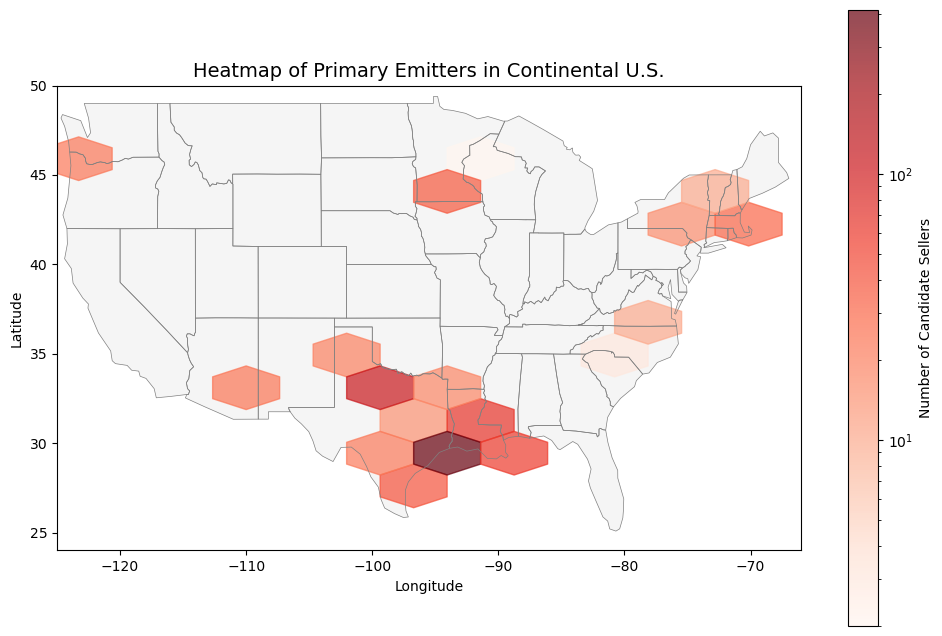

In [232]:
plot_usa_map(final_candidates, "Heatmap of Primary Emitters in Continental U.S.")

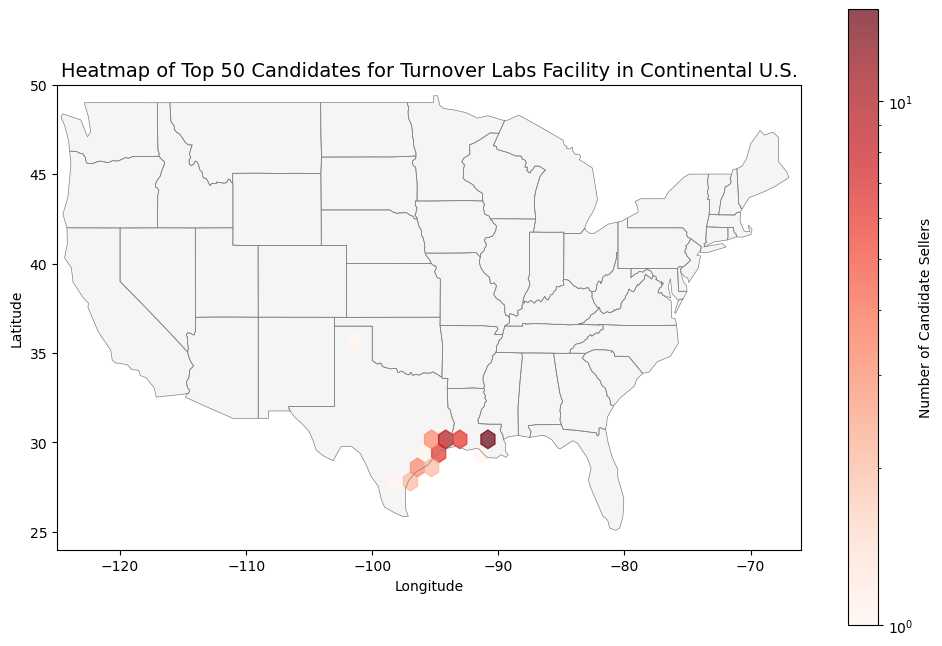

In [233]:
plot_usa_map(final_50_candidates, "Heatmap of Top 50 Candidates for Turnover Labs Facility in Continental U.S.")

# Based on filter of revenue, primary emitter is petrochemical, and there is high density of buyers within 50 km